In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nba_py import shotchart
from nba_py import player
import pandas as pd
from matplotlib import colors
import requests
import seaborn as sns
%matplotlib inline

In [3]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
plt.style.use('fivethirtyeight')

In [17]:
rockets_assists = pd.read_csv("../../Data/assist_chart/HOU.csv")

In [18]:
bb_ref_rockets = [
    "R. Anderson",
    "E. Gordon",
    "T. Ariza",
    "C. Capela"
]

In [19]:
harden_assists = rockets_assists.loc[rockets_assists.Passer == "J. Harden"]
harden_assists = harden_assists.loc[harden_assists.Scorer.isin(bb_ref_rockets)]
harden_assists = harden_assists.reset_index()

In [20]:
rockets_other = [
    ["Ryan", "Anderson"],
    ["Eric", "Gordon"],
    ["Trevor", "Ariza"],
    ["Clint", "Capela"]
]

In [9]:
player_id = player.get_player("Eric", "Gordon", season="2017-18")
player_data = shotchart.ShotChart(player_id=player_id, season="2017-18").shot_chart()
player_data.GAME_DATE = player_data.GAME_DATE.astype("int64")

In [22]:
harden_df = None
for rocket_player in rockets_other:
    player_id = player.get_player(rocket_player[0], rocket_player[1]).iloc[0]
    data = shotchart.ShotChart(player_id=player_id, season="2017-18").shot_chart()
    data.GAME_DATE = data.GAME_DATE.astype("int64")
    merged_df = pd.merge(harden_assists, data, on=["GAME_DATE", "MINUTES_REMAINING", "SECONDS_REMAINING", "PERIOD"])
    if harden_df is None:
        harden_df = merged_df
    else:
        harden_df = harden_df.append(merged_df, ignore_index=True)
    
    # harden_assists_only = data.loc[data.PLAYER_ID == harden_id]
    # harden_assists_only['SCORER'] = rocket_player[1]
    

In [23]:
harden_df.LOC_X = -harden_df.LOC_X # REAL DATA IS FLIPPED

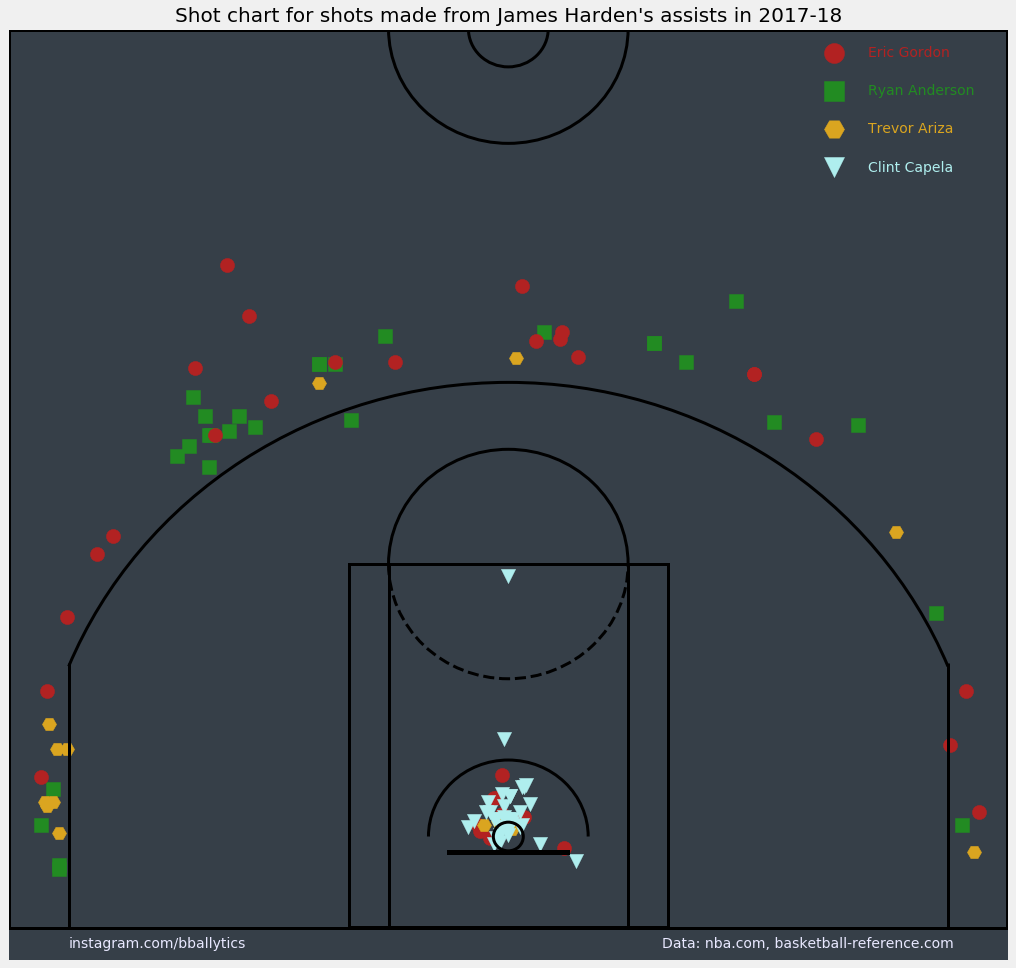

In [27]:
fig = plt.figure(figsize=(16, 16))
# colors_dict = {0:'red', 1:'green'}
cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

# LOC_PERCENTAGE -> total perc
# PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
# PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
# LOC_X, LOC_Y -> real locs
# BIN_LOC_X, BIN_LOC_Y -> binned locations
markers = {
    'Eric Gordon' : 'o',
    'Ryan Anderson' : 's',
    'Trevor Ariza' : 'H',
    'Clint Capela' : 'v'
}
colors = {
    'Eric Gordon' : '#B22222',
    'Ryan Anderson' : '#228B22',
    'Trevor Ariza' : '#DAA520',
    'Clint Capela' : '#AFEEEE'
}

for i in range(len(harden_df)):
    curr_series = harden_df.iloc[i]
    plt.scatter(x=curr_series.LOC_X, y=curr_series.LOC_Y, marker=markers[curr_series.PLAYER_NAME], c=colors[curr_series.PLAYER_NAME], s=200)


# Legend
plt.scatter(x=163, y=410, s=400, marker='o', c="#B22222")
plt.text(s="Eric Gordon", x = 180, y = 408, color="#B22222")
plt.scatter(x=163, y=390, s=400, marker='s', c="#228B22")
plt.text(s="Ryan Anderson", x = 180, y = 388, color="#228B22")
plt.scatter(x=163, y=370, s=400, marker='H', c="#DAA520")
plt.text(s="Trevor Ariza", x = 180, y = 368, color="#DAA520")
plt.scatter(x=163, y=350, s=400, marker='v', c="#AFEEEE")
plt.text(s="Clint Capela", x = 180, y = 348, color="#AFEEEE")


# Changing court color
plt.gca().set_facecolor('#363F48')
curr_ax = plt.gca()

#plt.xticks(np.arange(-250, 251, 20))
#plt.yticks(np.arange(-50, 490, 20))
# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shot chart for shots made from James Harden's assists in 2017-18", size=20)

# Drawing court
draw_court(outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-65,423)

plt.text(x=-220, y=-58, s="instagram.com/bballytics", color="#E8E8FF")
plt.text(x=77, y=-58, s="Data: nba.com, basketball-reference.com", color="#E8E8FF")


# Saving figure
#plt.savefig('lebron.png', bbox_inches='tight')
#colorbar.set_label('Comparison to league average percentages', color='#E2E2FF', size=16, coords=(1.5, 1.5))
plt.show()